### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.vision.interpret import *
import fastai; fastai.__version__

'1.0.55.dev0'

In [3]:
data_path = Path("../../data/siim_acr_pneu/"); data_path.ls()

[PosixPath('../../data/siim_acr_pneu/train'),
 PosixPath('../../data/siim_acr_pneu/clas_df.csv'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-test'),
 PosixPath('../../data/siim_acr_pneu/models'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-train'),
 PosixPath('../../data/siim_acr_pneu/train-rle.csv'),
 PosixPath('../../data/siim_acr_pneu/seg_df.csv'),
 PosixPath('../../data/siim_acr_pneu/learn'),
 PosixPath('../../data/siim_acr_pneu/test')]

In [4]:
torch.cuda.set_device(7)

In [5]:
from mask_functions import *
from skimage.measure import label

### Workflow

- 1) Run segmentation on all valid and test images
- 2) Run classification on all test valid and images
- 3) Find optimal thresh
- 4) Submit

In [6]:
# this is needed or div=False
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

In [7]:
sz = 224

In [151]:
clas_learn = Learner(**torch.load(data_path/f'learn/clas-chexpert-ft-resnext34-{sz}'))
seg_learn = Learner(**torch.load(data_path/f'learn/seg-chexpert-ft-resnext34-{sz}'))

### 1) Run seg on valid/test

In [152]:
seg_valid_probs, seg_valid_targs = seg_learn.get_preds(DatasetType.Valid)
seg_test_probs, seg_test_targs = seg_learn.get_preds(DatasetType.Test)

### 1a) Semantic Dice (deprecated)

In [153]:
def semantic_dice(input, target, t):
    '''
    semantic dice score with threshold 
    input: 1 mask probability per image
    target: 1 mask target per image
    '''
    input_hard = input[:,1,:,:] > t
    n = input_hard.shape[0]
    inputs = input_hard.float().view(n,-1)
    targs = target.float().view(n,-1)
    intersect = (inputs * targs).sum()
    union = (inputs+targs).sum()
    dice = ((2. * intersect) / union)
    return dice

In [154]:
# # dice scores at different probability thresholds
# for t in np.linspace(0,1,21):
#     d = semantic_dice(seg_valid_probs, seg_valid_targs, t=t)
#     print(t, d)

### 1b) Instance Dice

In [155]:
# rles for each validation image
train_rle_df = pd.read_csv(data_path/'train-rle.csv')
valid_image_ids = [Path(o).stem for o in seg_learn.data.valid_ds.items]
valid_rle_dict = {o:train_rle_df[train_rle_df.ImageId == o][' EncodedPixels'].values for o in valid_image_ids}

In [156]:
def rles2masks(rles):
    'convert rles into list of (1024,1024) binary (0,1) masks'
    masks = []
    for rle in rles:
        maskimg = PIL.Image.fromarray(rle2mask(rle, 1024, 1024).T.astype(np.uint8))
        assert np.all(np.unique(np.asarray(maskimg)) == np.array([0,255]))
        masks.append((np.asarray(maskimg)/255).astype(np.uint8))
    return masks

In [157]:
# create masks for all validation images
valid_instance_targs = [np.array(rles2masks(valid_rle_dict[k])) for k in valid_image_ids]
len(valid_instance_targs)

237

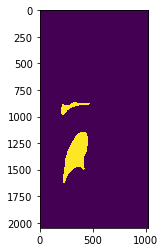

In [158]:
# test
masks = valid_instance_targs[0]
for m in masks: assert np.all(np.unique(m) == np.array([0,1]))
plt.imshow(np.concatenate(masks));

In [159]:
seg_test_probs.shape

torch.Size([1377, 2, 224, 224])

In [160]:
def prob2preds(prob, t):
    '''
    create instance preds from single mask probs 
    '''
    input_hard = prob[1,:,:] > t
    label_image = label(input_hard)
    unique_labels = np.unique(label_image)[1:]
    if len(unique_labels) > 0:
        instance_preds = [(label_image == l).astype(np.uint8) for l in unique_labels]
        instance_preds_resized = [np.asarray(PIL.Image.fromarray(arr).resize((1024,1024), 
                                    resample=PIL.Image.NEAREST)) for arr in instance_preds]
    else: instance_preds_resized = '-1'
    return np.array(instance_preds_resized)

In [161]:
t = 0.5
valid_instance_preds = [prob2preds(prob, t) for prob in seg_valid_probs]

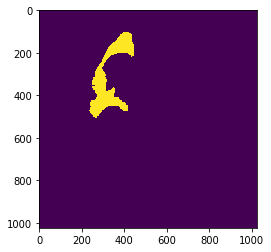

In [162]:
# test
masks = valid_instance_preds[0]
for m in masks: assert np.all(np.unique(m) == np.array([0,1]))
plt.imshow(np.concatenate(masks));

In [163]:
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm_notebook

def instance_dice(instance_preds, instance_targs):
    '''
    instance dice score with threshold 
    instance_preds: list of N_i mask (0,1) per image
    instance_targs: list of M_i mask (0,1) target per image
    '''
    
#     # for plotting
#     fig,axes=plt.subplots(1,2)
#     axes[0].imshow(np.concatenate(valid_instance_targs[i]))
#     axes[1].imshow(np.concatenate(valid_instance_preds[i]))
    
    scores = []
    for i in (range(len(instance_preds))):
        if np.all(valid_instance_preds[i] == np.array(['-1'])): scores.append(0)
        else:
            m,_,_ = valid_instance_targs[i].shape
            n,_,_ = valid_instance_preds[i].shape

            targs = valid_instance_targs[i].reshape(m,-1)
            preds = valid_instance_preds[i].reshape(n,-1)

            # intersect: matrix of targ x preds (M, N)
            intersect = ((targs[:,None,:]*preds[None,:,:]) > 0).sum(2)    
            targs_area, preds_area = targs.sum(1), preds.sum(1)
            union = targs_area[:, None] + preds_area[None,:]

            dice = (2*intersect / union); dice
            dice_scores = dice[linear_sum_assignment(1-dice)]
            mean_dice_score = sum(dice_scores) / max(n, m) # unmatched gt or preds are counted as 0
            scores.append(mean_dice_score)
    return scores

In [164]:
# at t = 0.5
best_dice, best_seg_thres = 0, None

for t in tqdm_notebook(np.linspace(0,1,21)):
    valid_instance_preds = [prob2preds(prob, t) for prob in seg_valid_probs]
    dice_score = np.mean(instance_dice(valid_instance_preds, valid_instance_targs))
    if dice_score > best_dice: best_dice, best_seg_thres= dice_score, t

/home/turgutluk/.conda/envs/my_fastai/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [165]:
best_dice, best_seg_thres

(0.3186035988035392, 0.30000000000000004)

### 2) Run clas on valid/test

In [166]:
from sklearn.metrics import confusion_matrix

In [167]:
clas_valid_probs, clas_valid_targs = clas_learn.get_preds(DatasetType.Valid)
clas_test_probs, clas_test_targs = clas_learn.get_preds(DatasetType.Test)

### 3) Grid search for best thres -  Calculate approx LB score 

In [168]:
def find_best_thres(best_dice=best_dice, best_seg_thres=best_seg_thres):
    "grid search cls_thres, seg_thres"
    best_score, best_cls_thres = 0, None
    
    for cls_thres in np.linspace(0,1,21):
        clas_valid_hard = clas_valid_probs[:, 1] > cls_thres
        cm = confusion_matrix(clas_valid_targs, clas_valid_hard)

        P_0_0 = cm[0,0] / cm[0, :].sum()
        P_1_1 = cm[1,1] / cm[1, :].sum()

        # public LB ratios
        R_1, R_0 = 0.7886, 0.2114
        score_cls, score_seg = R_1*P_1_1, R_0*P_0_0*best_dice
        total = score_cls + score_seg

        # update
        if total > best_score:
            best_score, best_cls_thres  = total, cls_thres

    return best_score, best_cls_thres, best_seg_thres

In [169]:
best_score, best_cls_thres, best_seg_thres = find_best_thres()

In [170]:
best_score, best_cls_thres, best_seg_thres

(0.8016543733499933, 0.15000000000000002, 0.30000000000000004)

### 4) Submit

- Convert segmentation probas to binary 
- Resize to 1024, 1024
- Separate instances
- Convert individual masks to rle

In [171]:
cls_thres, seg_thres = best_cls_thres, best_seg_thres

In [172]:
# convert all soft mask predictions to hard predictions
seg_test_hard = (seg_test_probs[:,1,:,:] > seg_thres).squeeze(1); seg_test_hard.shape

torch.Size([1377, 224, 224])

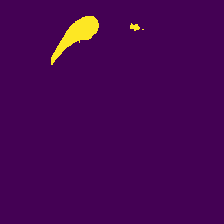

In [173]:
ImageSegment(seg_test_hard[4][None,:])

In [174]:
def tensor2pil(t):
    return (PIL.Image.fromarray((to_np(t)*255).astype(np.uint8), mode='L')
                .resize((1024,1024), PIL.Image.NEAREST))

In [175]:
def maskarray2rles(maskarray):
    rles = []
    labeled_maskarray = label(maskarray)
    unique_labels = list(np.unique(labeled_maskarray)[1:])
    for l in unique_labels:
        rle = mask2rle((labeled_maskarray == l).astype(np.uint8)*255, *(1024,1024))
        rles.append(rle)
    return rles

In [176]:
# extract test image ids
test_image_ids = np.array([o.stem for o in seg_learn.data.test_ds.items])

In [177]:
# find images to submit mask predictions for
has_pneumo = to_np((clas_test_probs[:, 1] < cls_thres)).astype(bool)

mask_test_image_ids = test_image_ids[has_pneumo]
mask_test_hard = seg_test_hard[tensor(has_pneumo)]

no_mask_test_image_ids = test_image_ids[~has_pneumo]

In [178]:
mask_test_image_ids.shape, no_mask_test_image_ids.shape, mask_test_hard.shape

((132,), (1245,), torch.Size([132, 224, 224]))

In [179]:
# create rle for all test predictions
all_image_ids = []
all_rles = []
for i in tqdm_notebook(range(len(mask_test_image_ids))):    
    image_id, t = mask_test_image_ids[i], mask_test_hard[i]
    maskimg = tensor2pil(t)
    maskarray = np.asarray(maskimg).T
    if len(np.unique(maskarray)) != 1: rles = maskarray2rles(maskarray)
    else: rles = ['-1']
    for rle in rles:
        all_image_ids.append(image_id)
        all_rles.append(rle)

In [180]:
len(all_image_ids), len(all_rles)

(283, 283)

In [181]:
sub1 = pd.DataFrame({"ImageId": all_image_ids, "EncodedPixels":all_rles})
sub2 = pd.DataFrame({"ImageId": no_mask_test_image_ids, "EncodedPixels":"-1"})

final_sub = pd.concat([sub1, sub2])
final_sub.to_csv("sub.csv", index=False)

In [182]:
sub2 = pd.DataFrame({"ImageId": no_mask_test_image_ids, "EncodedPixels":"-1"})

In [183]:
final_sub = pd.concat([sub1, sub2])

In [184]:
final_sub.to_csv("sub.csv", index=False)

In [185]:
from IPython.display import FileLink

In [150]:
FileLink("sub.csv")

/home/turgutluk/git/siim_acr_pneu/sub.csv